In [2]:
import numpy as np
import h5py
import random
import matplotlib.pyplot as plt
import scipy.io as readmat
import math
import brainiak.eventseg.event
import random
import time
import pickle
import joblib
import deepdish as dd
import os
import itertools

from tqdm import tqdm
from sklearn.model_selection import KFold
from FDR_p import FDR_p
from scipy.stats import norm, f_oneway

## Get averaged timecourses for each prime of each story

In [3]:
# Import data
prefix = 'Preprocessing/pickle/'
story_dict =  joblib.load(prefix + 'roi_storydict_ISC_36.sav')

story_lens = pickle.load(open(prefix + 'story_lens36.pickle', 'rb'))
event_lens = pickle.load(open(prefix + 'event_lens36.pickle', 'rb'))
ev_bounds = pickle.load(open(prefix + 'ev_bounds36.pickle', 'rb'))
listen_order = pickle.load(open(prefix + 'listen_order36.pickle', 'rb'))
timing = pickle.load(open(prefix + 'timing36.pickle', 'rb'))
participant_ev_bounds = pickle.load(open(prefix + 'participant_ev_bounds.pickle', 'rb'))
target_TRs = pickle.load(open('target_TRs.pickle', 'rb'))

In [4]:
cond_avg = dict()
for roi in ['mPFC', 'Ang', 'PHC']:
    print('Running ', roi, '...')
    n_vox = story_dict[roi][11].shape[1]
    cond_avg[roi] = {0: dict(), 1: dict(), 2: dict()}
    for story_i, story in enumerate(story_dict[roi]):
        np_all = np.zeros((0, n_vox, story_lens[story]['ISC']['L'].shape[1]))
        soc_all = np.zeros((0, n_vox, story_lens[story]['ISC']['L'].shape[1]))
        loc_all = np.zeros((0, n_vox, story_lens[story]['ISC']['L'].shape[1]))
        group_list = [np_all, soc_all, loc_all]
        # put each participant in correct priming group
        for sub_i, sub in enumerate(listen_order):
            for run in listen_order[sub]:
                for i in range(listen_order[sub][run].shape[0]):
                    if int(listen_order[sub][run][i][1]) == story:
                        this_prime = int(listen_order[sub][run][i][2])
                        this_sub = np.expand_dims(story_dict[roi][story][sub_i, :], axis=0)
                        group_list[this_prime] = np.append(group_list[this_prime], this_sub, axis=0)
        cond_avg[roi][0][story] = np.nanmean(group_list[0], axis=0)
        cond_avg[roi][1][story] = np.nanmean(group_list[1], axis=0)
        cond_avg[roi][2][story] = np.nanmean(group_list[2], axis=0)

Running  mPFC ...
Running  Ang ...
Running  PHC ...


In [5]:
def plot_normal(x_center, mu, sigma, width):
    y = np.arange(mu-3*sigma,mu+3*sigma,sigma/50)
    unnorm_width = 2*norm.pdf(mu, loc=mu, scale=sigma)
    
    x = x_center-norm.pdf(y, loc=mu, scale=sigma)*width/unnorm_width
    y2 = np.flip(y)
    x2 = x_center+norm.pdf(y, loc=mu, scale=sigma)*width/unnorm_width
    
    
    shape = plt.fill(np.concatenate((x,x2)), np.concatenate((y,y2)))[0]
    shape.set_facecolor('#808080')
    shape.set_edgecolor('black')
    shape.set_alpha(.3)

In [6]:
def plot_results(alignment):
    for roi in ['mPFC', 'Ang', 'PHC']:
        plt.rcParams['figure.figsize'] = [16, 8]
        fig = plt.figure()

        # Create an axes instance
        ax = fig.add_axes([0,0,0.6,1])

        plt.rcParams.update({'font.size': 22})
        plt.tick_params(axis='x', which='minor',bottom=False, top=False, labelbottom=False)

        priming_colors = ["#E6AF2E", "#2B6681", "#E93423"]

        # location comparisons
        ax.plot(.9, alignment[roi][0]['loc'][0], marker="o", markersize=20, markeredgecolor='#E6AF2E', markerfacecolor='#E6AF2E', linestyle="None")
        ax.plot(1, alignment[roi][2]['loc'][0], marker="o", markersize=20, markeredgecolor='#E93423', markerfacecolor='#E93423', linestyle="None")
        ax.plot(1.1, alignment[roi][1]['loc'][0], marker="o", markersize=20, markeredgecolor='#2B6681', markerfacecolor='#2B6681', linestyle="None")

        # social comparison
        shift = 0.7
        ax.plot(.9+shift, alignment[roi][0]['soc'][0], marker="o", markersize=20, markeredgecolor='#E6AF2E', markerfacecolor='#E6AF2E', linestyle="None")
        ax.plot(1+shift, alignment[roi][2]['soc'][0], marker="o", markersize=20, markeredgecolor='#E93423', markerfacecolor='#E93423', linestyle="None")
        ax.plot(1.1+shift, alignment[roi][1]['soc'][0], marker="o", markersize=20, markeredgecolor='#2B6681', markerfacecolor='#2B6681', linestyle="None")

        null =  np.concatenate((np.concatenate([alignment[roi][prime]['loc'][1:] for prime in np.arange(3)]),
                                np.concatenate([alignment[roi][prime]['soc'][1:] for prime in np.arange(3)])))

        plot_normal(1,null.mean(), null.std(), 0.4)
        plot_normal(1+shift,null.mean(), null.std(), 0.4)

        ax.set_xticks([1,1+shift], minor=False)
        ax.set_xticklabels(['Location\nboundaries', 'Social\nboundaries'], fontsize=25)
        ax.set_ylabel('HMM Event Change\n at Event Boundaries', fontsize = 25)

        print(roi)

        # location boundaries
        print('Location boundaries...')
        pval = norm.sf((alignment[roi][0]['loc'][0]-null.mean())/null.std())
        print('No prime pval: ', pval)
        pval = norm.sf((alignment[roi][2]['loc'][0]-null.mean())/null.std())
        print('Loc pval: ', pval)
        pval = norm.sf((alignment[roi][1]['loc'][0]-null.mean())/null.std())
        print('Soc pval: ', pval)

        prime_diff = alignment[roi][2]['loc'] - np.mean([alignment[roi][0]['loc'], alignment[roi][1]['loc']], axis = 0)
        p = norm.sf((prime_diff[0] - prime_diff[1:].mean())/prime_diff[1:].std())
        print('loc -  non-loc dif: ', p)

        # social boundaries
        print('Social boundaries...')
        pval = norm.sf((alignment[roi][0]['soc'][0]-null.mean())/null.std())
        print('No prime pval: ', pval)
        pval = norm.sf((alignment[roi][2]['soc'][0]-null.mean())/null.std())
        print('Loc pval: ', pval)
        pval = norm.sf((alignment[roi][1]['soc'][0]-null.mean())/null.std())
        print('Soc pval: ', pval)

        prime_diff = np.mean([alignment[roi][0]['soc'], alignment[roi][1]['soc']], axis = 0) - alignment[roi][2]['soc']
        p = norm.sf((prime_diff[0] - prime_diff[1:].mean())/prime_diff[1:].std())
        print('non-loc - loc dif: ', p)


        ax = fig.add_axes([0.8,0,0.2,1])
        plt.rcParams.update({'font.size': 22})
        plt.tick_params(axis='x', which='minor',bottom=False, top=False, labelbottom=False)

        # diff
        bound_diff = [alignment[roi][p]['loc']-alignment[roi][p]['soc'] for p in range(3)]
        ax.plot(0.9, bound_diff[0][0], marker="o", markersize=20, markeredgecolor='#E6AF2E', markerfacecolor='#E6AF2E', linestyle="None")
        ax.plot(1, bound_diff[2][0], marker="o", markersize=20, markeredgecolor='#E93423', markerfacecolor='#E93423', linestyle="None")
        ax.plot(1.1, bound_diff[1][0], marker="o", markersize=20, markeredgecolor='#2B6681', markerfacecolor='#2B6681', linestyle="None")

        ax.set_ylabel('HMM Event Change\nat Location vs Social Boundaries', fontsize = 25)
        ax.set_xticks([])

        null =  np.concatenate([bound_diff[prime][1:] for prime in np.arange(3)])
        plot_normal(1,null[1:].mean(), null[1:].std(), 0.4)

        prime_diff = bound_diff[2]-np.mean(bound_diff[0:2], axis=0)
        p = norm.sf((prime_diff[0] - prime_diff[1:].mean())/prime_diff[1:].std())
        print('Overall prime effect:',p)

## Main analysis: HMM evchange for event boundaries

In [34]:
alignment = dict()

for roi in ['mPFC', 'Ang', 'PHC']:
    print('Running ', roi, '...')
    alignment[roi] = dict()
    
    # Get each priming group's alignments with loc and soc boundaries
    prime_names = ['np', 'soc', 'loc']
    n_perms = 24

    for this_prime in [0,1,2]:
        alignment[roi][this_prime] = {'loc': np.zeros((16, n_perms)), 'soc': np.zeros((16, n_perms))}
        for story_i, story in enumerate(story_dict[roi]):
            group_avg = cond_avg[roi][this_prime][story]
            HMM = brainiak.eventseg.event.EventSegment(4)
            HMM.fit(group_avg.T)

            these_segs = HMM.segments_[0]
            exp_val = np.dot(these_segs, np.arange(these_segs.shape[1]))
            np_patchange = np.diff(exp_val)
            
            loc_ev_len = np.diff(ev_bounds[story]['ISC']['location'])
            soc_ev_len = np.diff(ev_bounds[story]['ISC']['social'])
            
            alignment[roi][this_prime]['loc'][story_i, :] = \
                [np_patchange[np.cumsum(ev_order)[0:3]].mean() for ev_order in itertools.permutations(loc_ev_len)]
            alignment[roi][this_prime]['soc'][story_i, :] = \
                [np_patchange[np.cumsum(ev_order)[0:3]].mean() for ev_order in itertools.permutations(soc_ev_len)]
        
        alignment[roi][this_prime]['loc'] = alignment[roi][this_prime]['loc'].mean(0)
        alignment[roi][this_prime]['soc'] = alignment[roi][this_prime]['soc'].mean(0)                

Running  mPFC ...
Running  Ang ...
Running  PHC ...


mPFC
Location boundaries...
No prime pval:  0.6055694617448081
Loc pval:  0.039021518965044806
Soc pval:  0.6446813896822221
loc -  non-loc dif:  0.013307410214731813
Social boundaries...
No prime pval:  0.08472397595519682
Loc pval:  0.6796097623531762
Soc pval:  0.13308346029529677
non-loc - loc dif:  0.0194445920125178
Overall prime effect: 0.007323946381944864
Ang
Location boundaries...
No prime pval:  0.7166395501225851
Loc pval:  0.5718357941258034
Soc pval:  0.43460899549773796
loc -  non-loc dif:  0.8414684965454264
Social boundaries...
No prime pval:  0.04242076262291466
Loc pval:  0.8201148947189056
Soc pval:  0.07509487336628658
non-loc - loc dif:  0.02968321205203525
Overall prime effect: 0.12601746304932626
PHC
Location boundaries...
No prime pval:  0.24383609780804405
Loc pval:  0.12225053310510692
Soc pval:  0.7103086311852218
loc -  non-loc dif:  0.13809992450311043
Social boundaries...
No prime pval:  0.46756903101855324
Loc pval:  0.8886493007569871
Soc pval:  0.70291

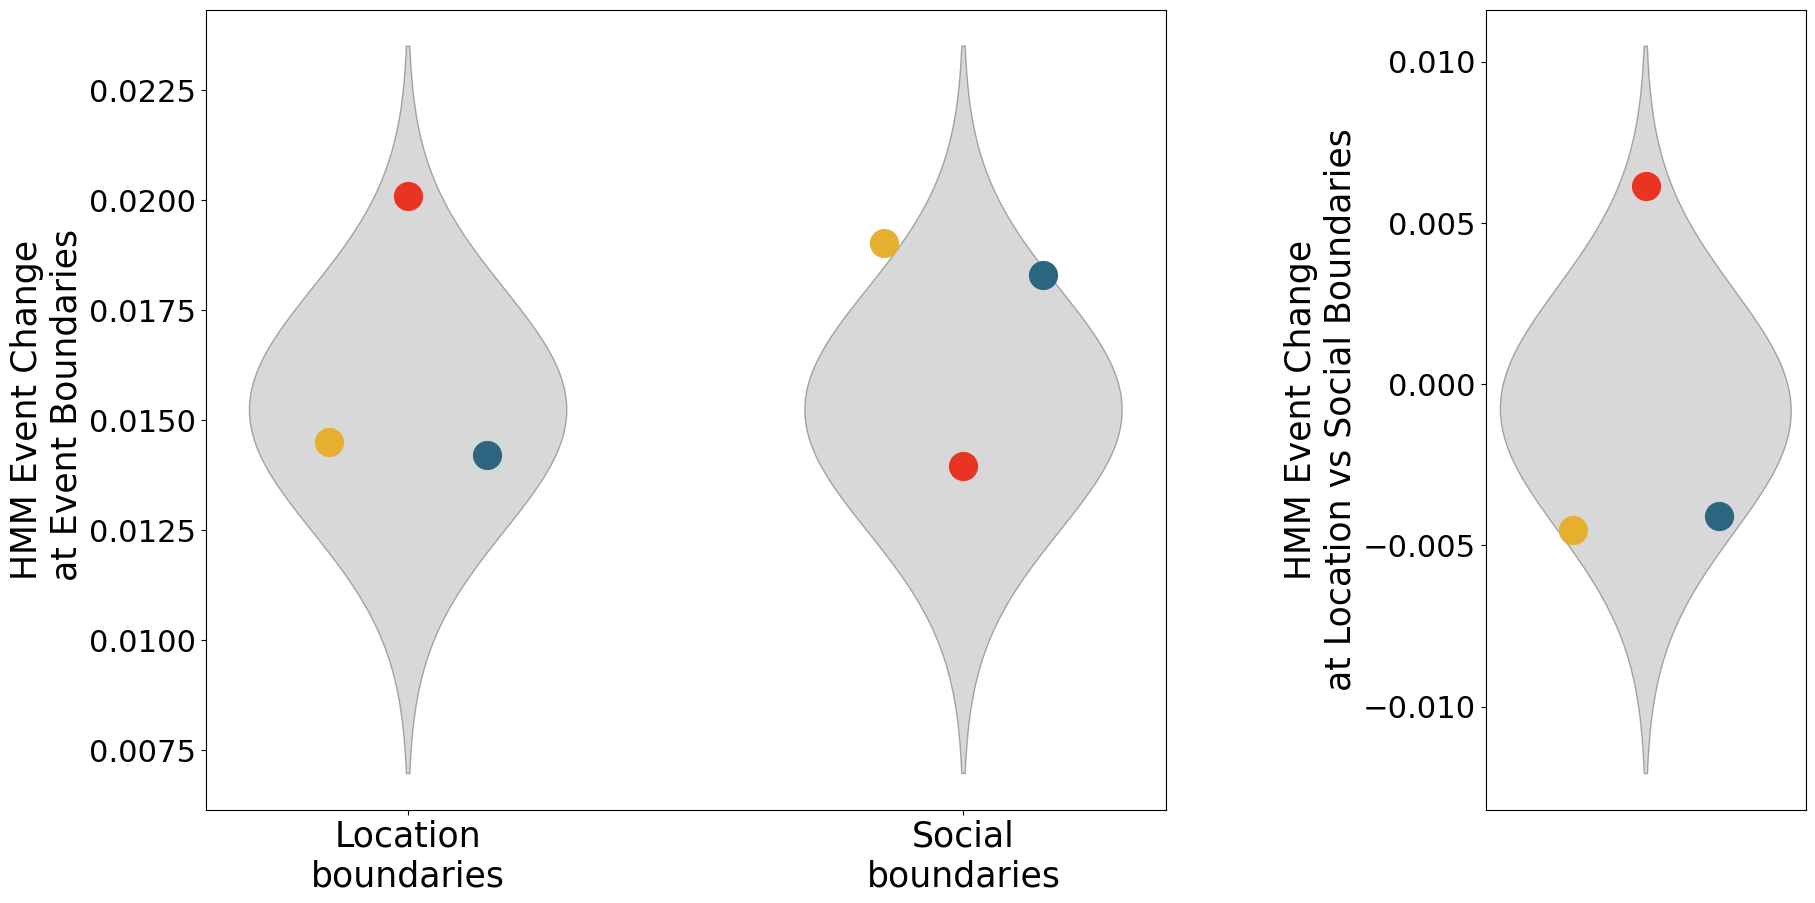

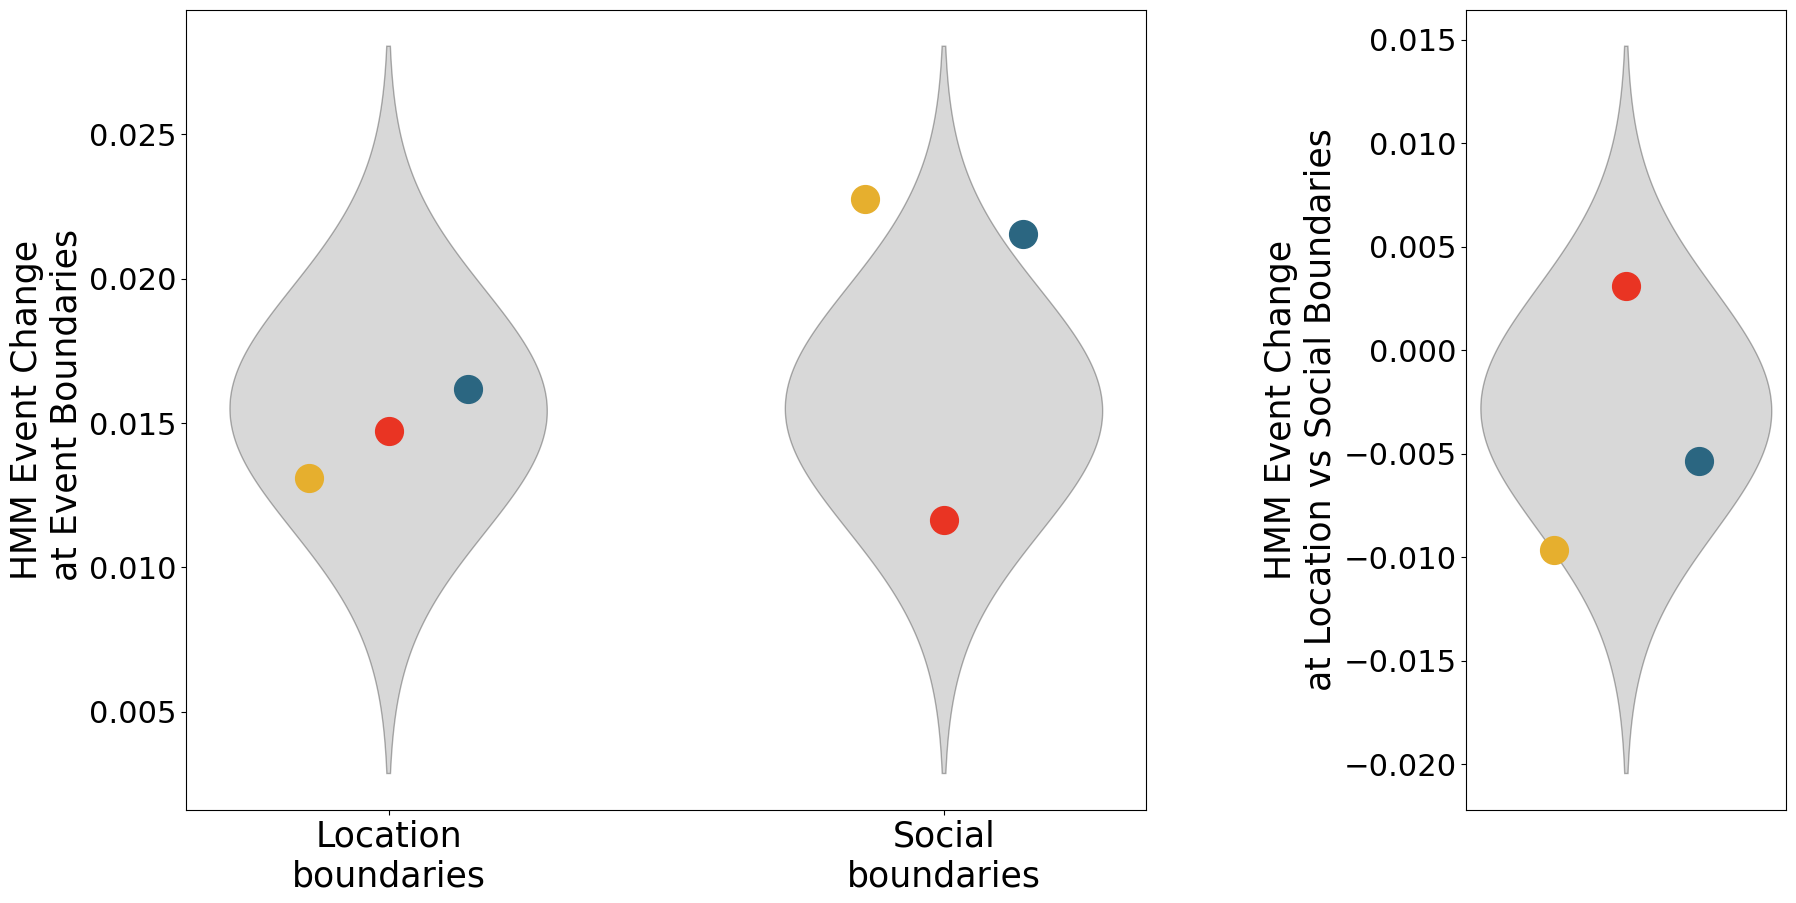

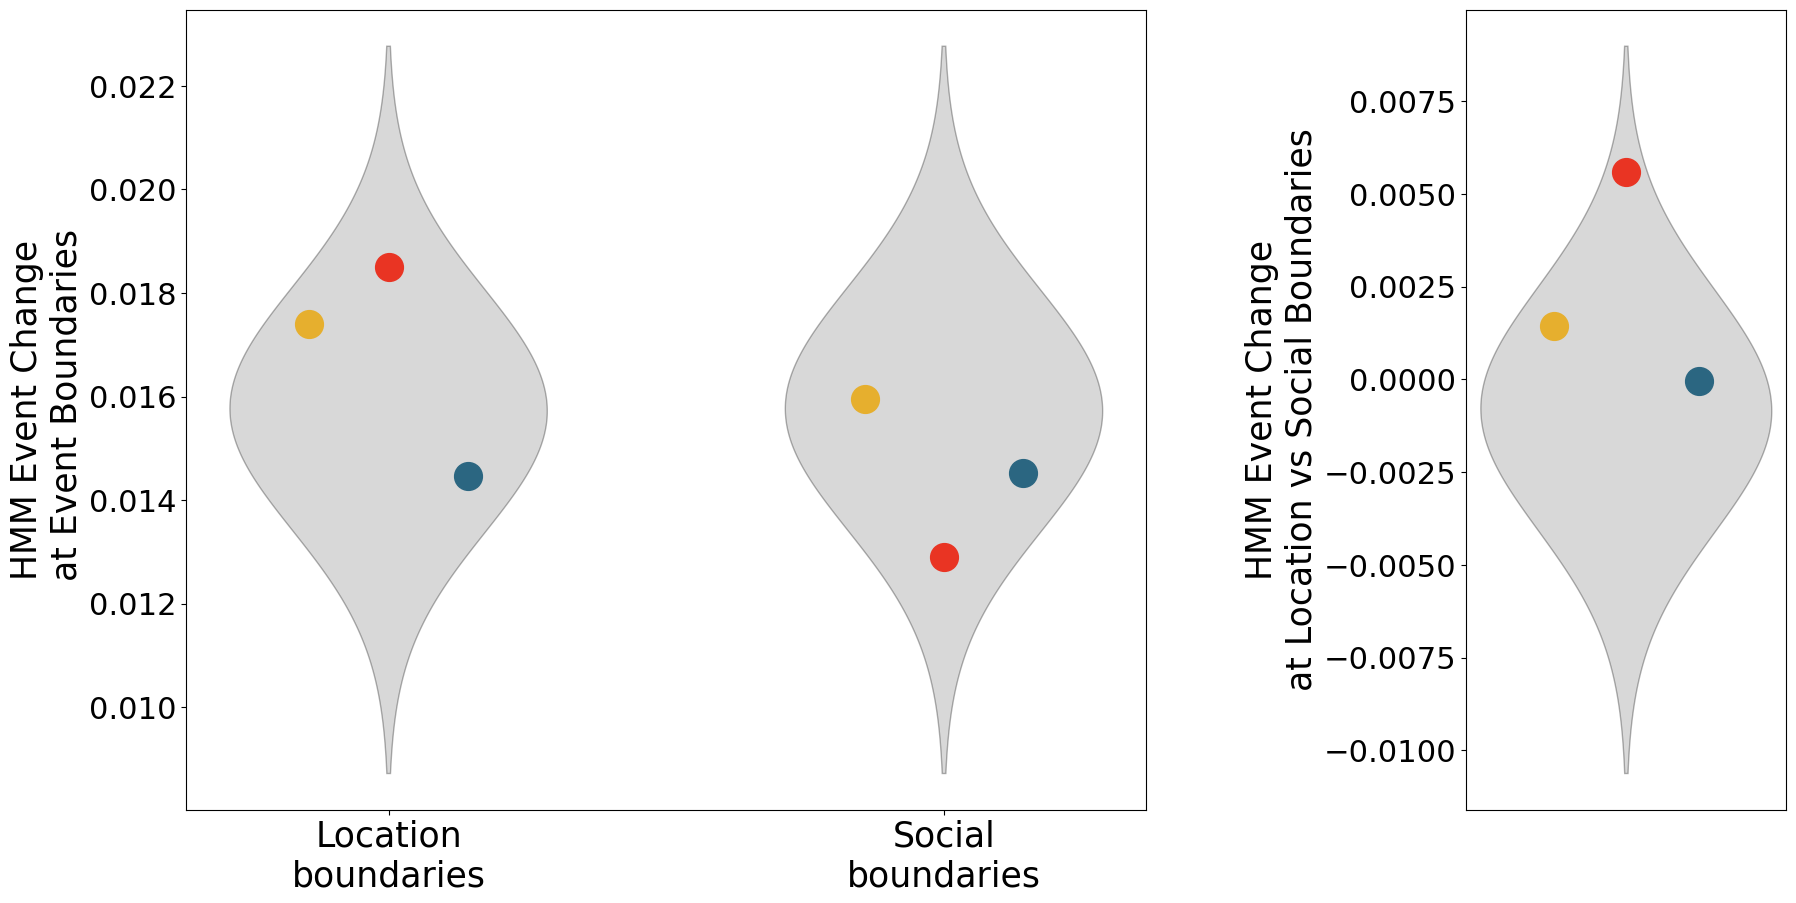

In [35]:
plot_results(alignment)

## Alternate: define hard HMM bounds

In [8]:
alignment = dict()

threshold = 4
for roi in ['mPFC', 'Ang', 'PHC']:
    print('Running ', roi, '...')
    alignment[roi] = dict()
    
    # Get each priming group's alignments with loc and soc boundaries
    prime_names = ['np', 'soc', 'loc']
    n_perms = 24

    for this_prime in [0,1,2]:
        alignment[roi][this_prime] = {'loc': np.zeros((16, n_perms)), 'soc': np.zeros((16, n_perms))}
        for story_i, story in enumerate(story_dict[roi]):
            group_avg = cond_avg[roi][this_prime][story]
            HMM = brainiak.eventseg.event.EventSegment(4)
            HMM.fit(group_avg.T)

            these_segs = HMM.segments_[0]
            HMM_bounds = np.where(np.diff(np.argmax(these_segs, axis=1)))[0]
            
            bound_diff = np.add.outer(np.arange(group_avg.shape[1]),-1*HMM_bounds)
            peri_bound = np.any((bound_diff >= -1*threshold)*(bound_diff <= threshold), axis=1)
            
            loc_ev_len = np.diff(ev_bounds[story]['ISC']['location'])
            soc_ev_len = np.diff(ev_bounds[story]['ISC']['social'])
            
            alignment[roi][this_prime]['loc'][story_i, :] = \
                [peri_bound[np.cumsum(ev_order)[0:3]].mean() for ev_order in itertools.permutations(loc_ev_len)]
            alignment[roi][this_prime]['soc'][story_i, :] = \
                [peri_bound[np.cumsum(ev_order)[0:3]].mean() for ev_order in itertools.permutations(soc_ev_len)]
        
        alignment[roi][this_prime]['loc'] = alignment[roi][this_prime]['loc'].mean(0)
        alignment[roi][this_prime]['soc'] = alignment[roi][this_prime]['soc'].mean(0)                

Running  mPFC ...
Running  Ang ...
Running  PHC ...


mPFC
Location boundaries...
No prime pval:  0.712074938879772
Loc pval:  0.06618150509910427
Soc pval:  0.8345537326361308
loc -  non-loc dif:  0.015295031059512005
Social boundaries...
No prime pval:  0.13741928902809286
Loc pval:  0.5582743816458566
Soc pval:  0.39501738802191
non-loc - loc dif:  0.04915186059608593
Overall prime effect: 0.004929843534092778
Ang
Location boundaries...
No prime pval:  0.7642565554117348
Loc pval:  0.5863635808380281
Soc pval:  0.38833519004889555
loc -  non-loc dif:  0.8942259683646079
Social boundaries...
No prime pval:  0.0989803466028158
Loc pval:  0.8891316665213431
Soc pval:  0.38833519004889555
non-loc - loc dif:  0.02210967519089722
Overall prime effect: 0.19360698060453435
PHC
Location boundaries...
No prime pval:  0.8876104576336892
Loc pval:  0.6134756329715157
Soc pval:  0.7737198908998191
loc -  non-loc dif:  0.05368673941745175
Social boundaries...
No prime pval:  0.2620170824011179
Loc pval:  0.7737198908998191
Soc pval:  0.6134756329715

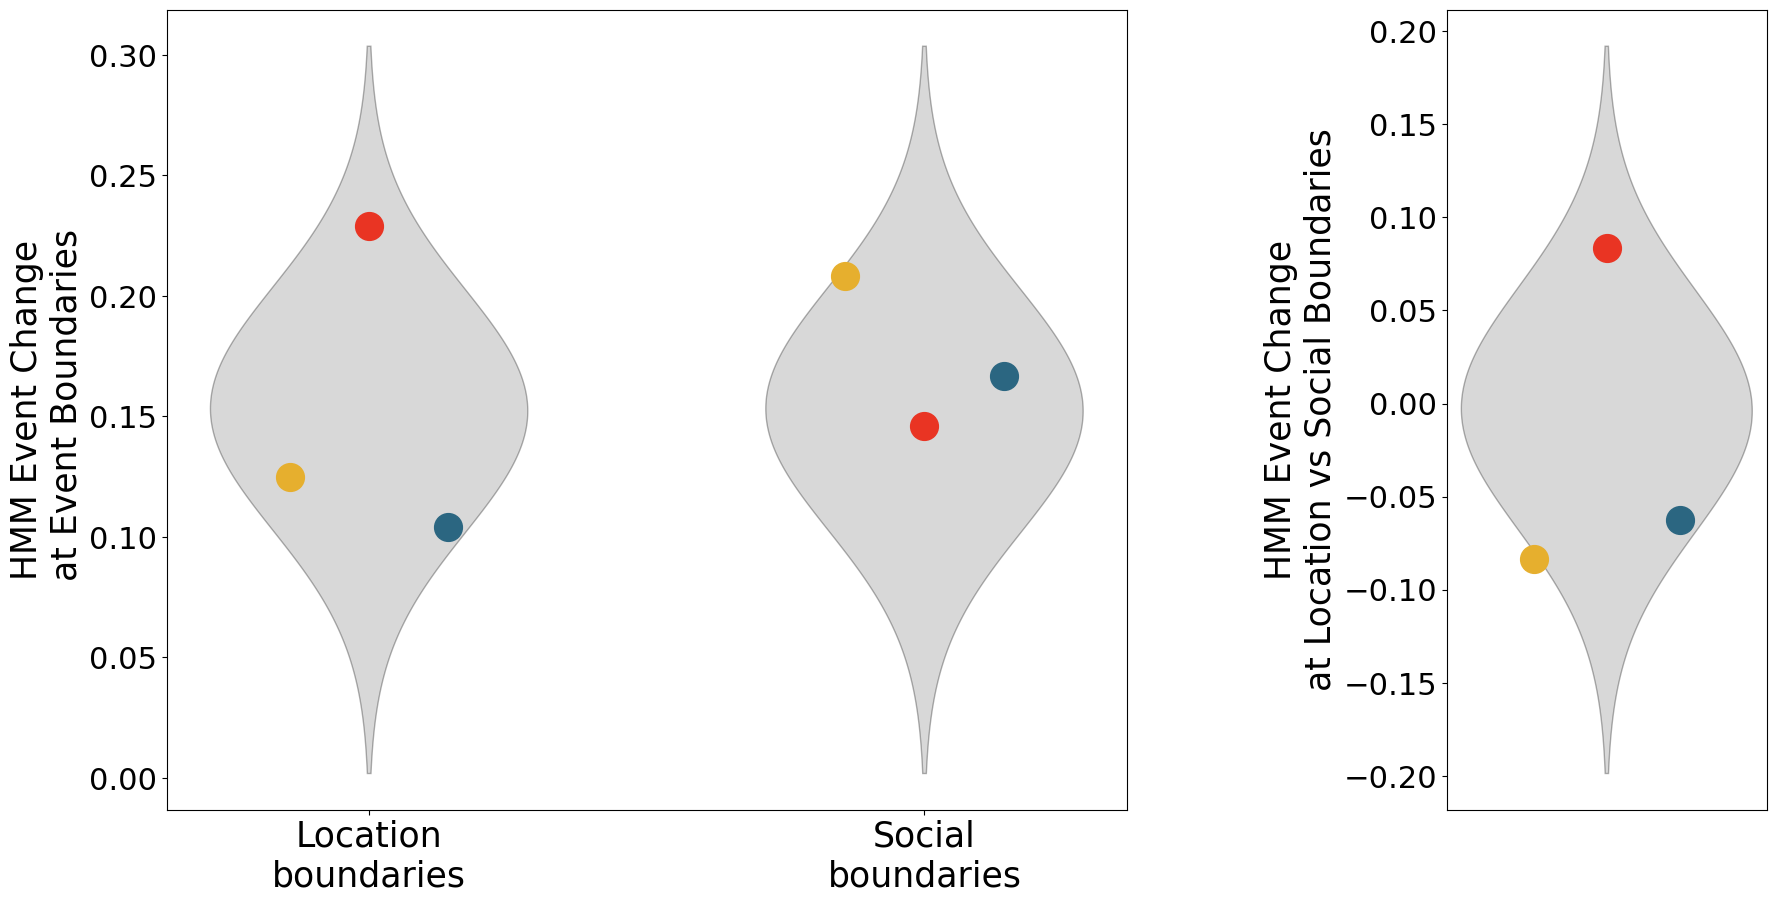

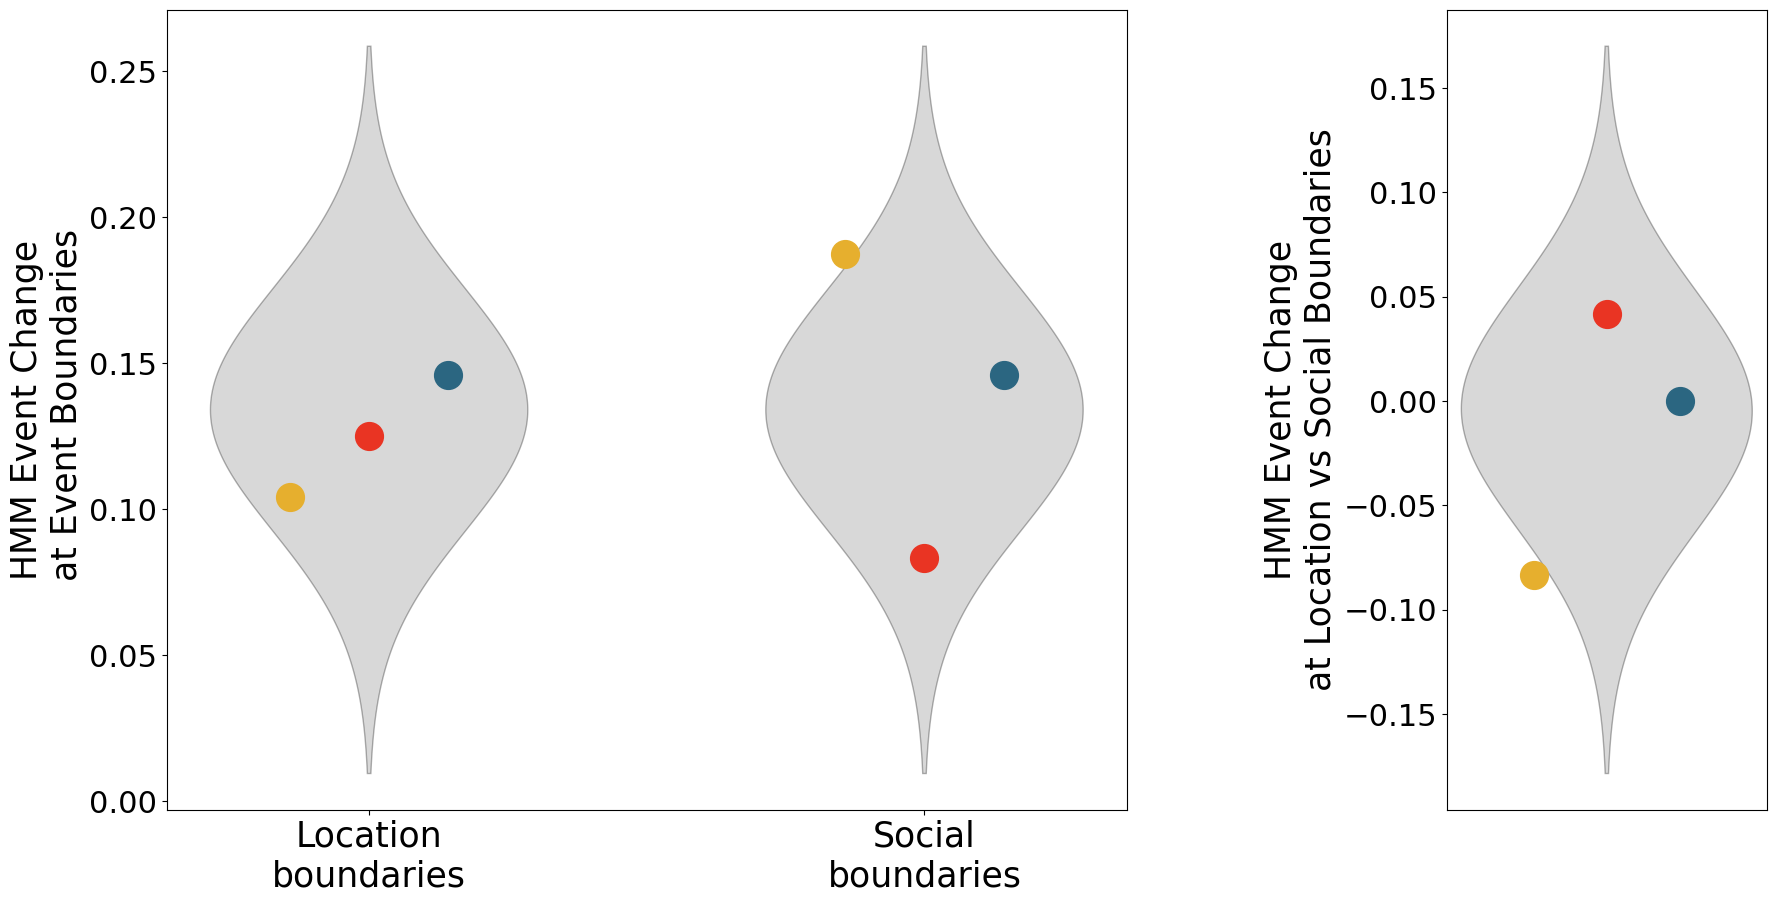

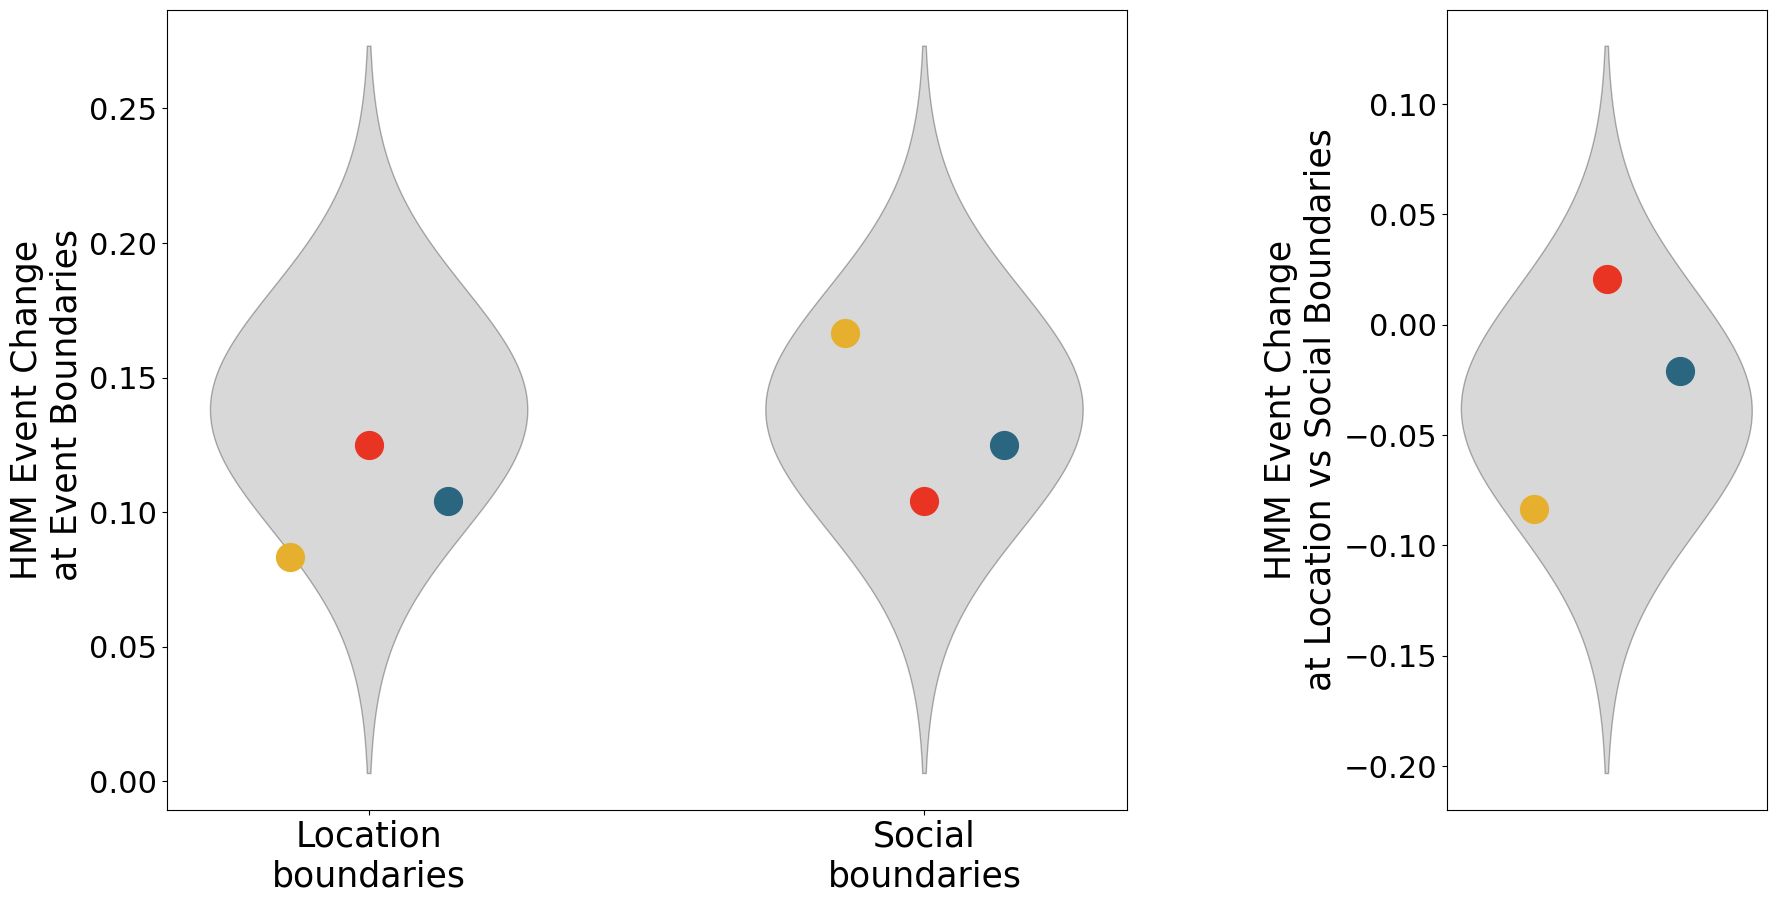

In [9]:
plot_results(alignment)

## Alternate: raw pattern correlation shift at boundaries

In [10]:
roi = 'mPFC'
gap = 4
winsize = 20
trigger = np.zeros((3, 2, 2*winsize)) #prime, type, window
    
# Get each priming group's alignments with loc and soc boundaries
prime_names = ['np', 'soc', 'loc']
n_perms = 24

for this_prime in [0,1,2]:
    for story_i, story in enumerate(story_dict[roi]):
        group_avg = cond_avg[roi][this_prime][story]

        for bound_type_i, bound_type in enumerate(['location', 'social']):
            for b in ev_bounds[story]['ISC'][bound_type]:
                for offset in np.arange(-1*winsize, winsize):
                    center = b+offset
                    if center+gap < group_avg.shape[1] and center-gap >= 0:
                        trigger[this_prime, bound_type_i, offset+winsize] += \
                        np.corrcoef(group_avg[:,center-gap//2], group_avg[:,center+gap//2+1])[0,1]/(3*16) # 3 bounds * 16 stories             

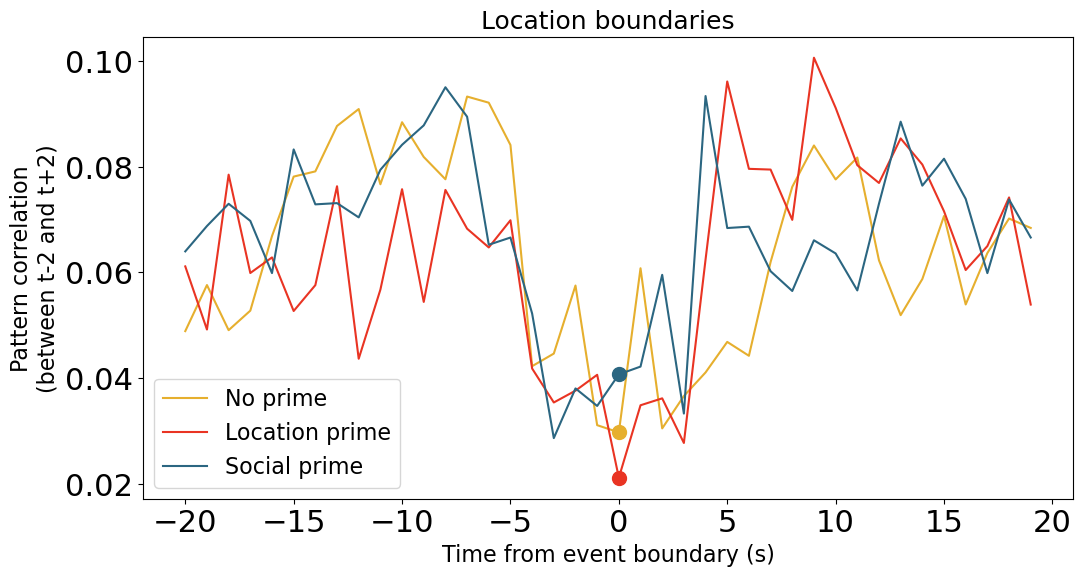

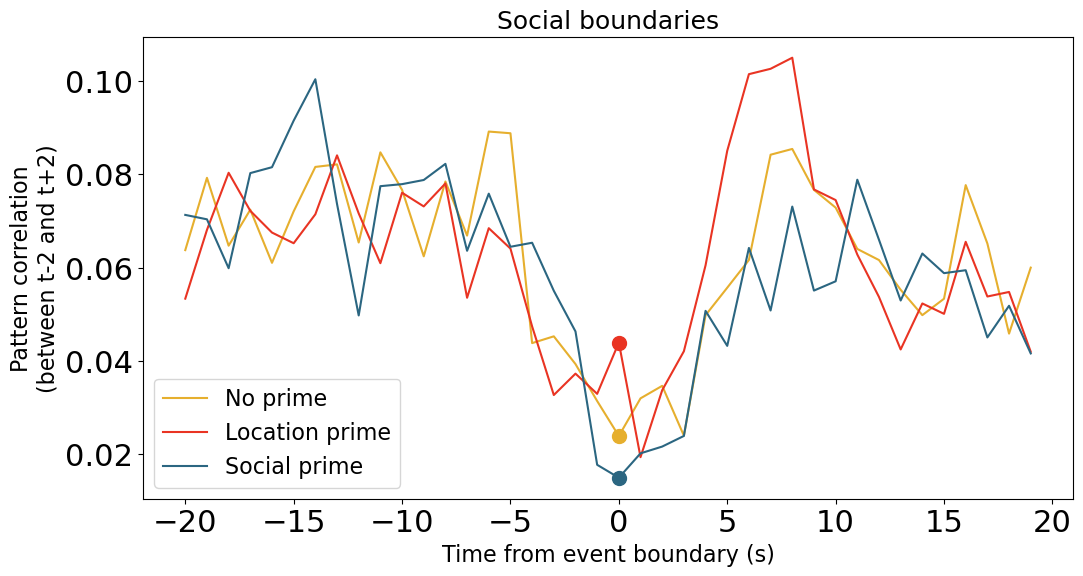

In [25]:
priming_colors = ["#E6AF2E", "#2B6681", "#E93423"]
for bound_type_i, bound_type in enumerate(['location', 'social']):
    plt.figure(figsize=(12,6))
    for p in [0,2,1]:
        plt.plot(np.arange(-1*winsize, winsize),trigger[p,bound_type_i,:], color=priming_colors[p])
    plt.plot(0, trigger[0,bound_type_i,winsize], marker="o", markersize=10, markeredgecolor='#E6AF2E', markerfacecolor='#E6AF2E', linestyle="None")
    plt.plot(0, trigger[2,bound_type_i,winsize], marker="o", markersize=10, markeredgecolor='#E93423', markerfacecolor='#E93423', linestyle="None")
    plt.plot(0, trigger[1,bound_type_i,winsize], marker="o", markersize=10, markeredgecolor='#2B6681', markerfacecolor='#2B6681', linestyle="None")

    if bound_type == 'location':
        plt.title('Location boundaries', fontsize=18)
    else:
        plt.title('Social boundaries', fontsize=18)
    plt.xlabel('Time from event boundary (s)',  fontsize=16)
    plt.ylabel('Pattern correlation\n(between t-2 and t+2)',  fontsize=16)
    plt.legend(['No prime','Location prime','Social prime'],  fontsize=16, loc='lower left')

In [26]:
pat_shift = dict()

gap = 4
for roi in ['mPFC', 'Ang', 'PHC']:
    print('Running ', roi, '...')
    pat_shift[roi] = dict()
    
    # Get each priming group's alignments with loc and soc boundaries
    prime_names = ['np', 'soc', 'loc']
    n_perms = 24

    for this_prime in [0,1,2]:
        pat_shift[roi][this_prime] = {'location': np.zeros((16, n_perms)), 'social': np.zeros((16, n_perms))}
        for story_i, story in enumerate(story_dict[roi]):
            group_avg = cond_avg[roi][this_prime][story]
            
            for bound_type in ['location', 'social']:
                ev_len = np.diff(ev_bounds[story]['ISC'][bound_type])
                loc_bounds = [np.cumsum(ev_order)[0:3] for ev_order in itertools.permutations(ev_len)]
                for p in range(n_perms):
                    cc = 0
                    for b in loc_bounds[p]:
                        cc += np.corrcoef(group_avg[:,b-gap//2], group_avg[:,b+gap//2+1])[0,1]/3
                    pat_shift[roi][this_prime][bound_type][story_i, p] = cc
        
        pat_shift[roi][this_prime]['location'] = pat_shift[roi][this_prime]['location'].mean(0)
        pat_shift[roi][this_prime]['social'] = pat_shift[roi][this_prime]['social'].mean(0)                

Running  mPFC ...
Running  Ang ...
Running  PHC ...


In [32]:
for roi in ['mPFC', 'Ang', 'PHC']:
    print(roi)
    
    null =  np.concatenate((np.concatenate([pat_shift[roi][prime]['location'][1:] for prime in np.arange(3)]),
                            np.concatenate([pat_shift[roi][prime]['social'][1:] for prime in np.arange(3)])))
    # location boundaries
    print('Location boundaries...')
    pval = norm.sf(-1*(pat_shift[roi][0]['location'][0]-null.mean())/null.std())
    print('No prime pval: ', pval)
    pval = norm.sf(-1*(pat_shift[roi][2]['location'][0]-null.mean())/null.std())
    print('Loc pval: ', pval)
    pval = norm.sf(-1*(pat_shift[roi][1]['location'][0]-null.mean())/null.std())
    print('Soc pval: ', pval)

    prime_diff = pat_shift[roi][2]['location'] - np.mean([pat_shift[roi][0]['location'], pat_shift[roi][1]['location']], axis = 0)
    p = norm.sf(-1*(prime_diff[0] - prime_diff[1:].mean())/prime_diff[1:].std())
    print('loc -  non-loc dif: ', p)

    # social boundaries
    print('Social boundaries...')
    pval = norm.sf(-1*(pat_shift[roi][0]['social'][0]-null.mean())/null.std())
    print('No prime pval: ', pval)
    pval = norm.sf(-1*(pat_shift[roi][2]['social'][0]-null.mean())/null.std())
    print('Loc pval: ', pval)
    pval = norm.sf(-1*(pat_shift[roi][1]['social'][0]-null.mean())/null.std())
    print('Soc pval: ', pval)

    prime_diff = np.mean([pat_shift[roi][0]['social'], pat_shift[roi][1]['social']], axis = 0) - pat_shift[roi][2]['social']
    p = norm.sf(-1*(prime_diff[0] - prime_diff[1:].mean())/prime_diff[1:].std())
    print('non-loc - loc dif: ', p)
    
    # diff
    bound_diff = [pat_shift[roi][p]['location']-pat_shift[roi][p]['social'] for p in range(3)]
    prime_diff = bound_diff[2]-np.mean(bound_diff[0:2], axis=0)
    p = norm.sf(-1*(prime_diff[0] - prime_diff[1:].mean())/prime_diff[1:].std())
    print('Overall prime effect:',p)

mPFC
Location boundaries...
No prime pval:  0.09048839488867755
Loc pval:  0.022055071778722648
Soc pval:  0.31735905195862885
loc -  non-loc dif:  0.5240013036838231
Social boundaries...
No prime pval:  0.03669795539188623
Loc pval:  0.4139241511260646
Soc pval:  0.006339464138288337
non-loc - loc dif:  0.03131340648874269
Overall prime effect: 0.09725248289252264
Ang
Location boundaries...
No prime pval:  0.19017316271384155
Loc pval:  0.3805699488574456
Soc pval:  0.4098687260969836
loc -  non-loc dif:  0.8238695431836186
Social boundaries...
No prime pval:  0.01599696028489577
Loc pval:  0.3484185132551946
Soc pval:  0.010643650122456886
non-loc - loc dif:  0.040000049839862994
Overall prime effect: 0.17213206929398223
PHC
Location boundaries...
No prime pval:  0.12260198056692662
Loc pval:  0.8660422294435564
Soc pval:  0.27825692595525997
loc -  non-loc dif:  0.9363485434422887
Social boundaries...
No prime pval:  0.023730079739721407
Loc pval:  0.7977281781369867
Soc pval:  0.06

## Alternate: HMM evchange at target sentences

In [7]:
alignment = dict()

for roi in ['mPFC', 'Ang', 'PHC']:
    print('Running ', roi, '...')
    alignment[roi] = dict()
    
    # Get each priming group's alignments with loc and soc boundaries
    prime_names = ['np', 'soc', 'loc']
    n_perms = 24*5

    for this_prime in [0,1,2]:
        alignment[roi][this_prime] = {'loc': np.zeros((16, n_perms)), 'soc': np.zeros((16, n_perms))}
        for story_i, story in enumerate(story_dict[roi]):
            group_avg = cond_avg[roi][this_prime][story]
            HMM = brainiak.eventseg.event.EventSegment(5)
            HMM.fit(group_avg.T)

            these_segs = HMM.segments_[0]
            exp_val = np.dot(these_segs, np.arange(these_segs.shape[1]))
            np_patchange = np.diff(exp_val)
            
            loc_ev_len = np.diff(np.concatenate(([0],target_TRs[story]['location'],[group_avg.shape[1]])))
            soc_ev_len = np.diff(np.concatenate(([0],target_TRs[story]['social'],[group_avg.shape[1]])))
            
            alignment[roi][this_prime]['loc'][story_i, :] = \
                [np_patchange[np.cumsum(ev_order)[0:3]].mean() for ev_order in itertools.permutations(loc_ev_len)]
            alignment[roi][this_prime]['soc'][story_i, :] = \
                [np_patchange[np.cumsum(ev_order)[0:3]].mean() for ev_order in itertools.permutations(soc_ev_len)]
        
        alignment[roi][this_prime]['loc'] = alignment[roi][this_prime]['loc'].mean(0)
        alignment[roi][this_prime]['soc'] = alignment[roi][this_prime]['soc'].mean(0)                

Running  mPFC ...
Running  Ang ...
Running  PHC ...


mPFC
Location targets...
No prime pval:  0.06781893535219714
Loc pval:  0.06379139829682035
Soc pval:  0.4993450397515697
loc -  non-loc dif:  0.15074360070879317
Social targets...
No prime pval:  0.8044172971406468
Loc pval:  0.24024172662107107
Soc pval:  0.5200513914926946
non-loc - loc dif:  0.9872275222705407
Overall prime effect: 0.9402069486320821
Ang
Location targets...
No prime pval:  0.17528386078740366
Loc pval:  0.015514708252136845
Soc pval:  0.7464056131260066
loc -  non-loc dif:  0.033049971311790514
Social targets...
No prime pval:  0.7424911975687858
Loc pval:  0.7052367832544633
Soc pval:  0.5651058958100059
non-loc - loc dif:  0.5249023144610322
Overall prime effect: 0.09849622326926577
PHC
Location targets...
No prime pval:  0.4297271773032706
Loc pval:  0.7177132065423479
Soc pval:  0.8144656657492723
loc -  non-loc dif:  0.6808420374502203
Social targets...
No prime pval:  0.7154823241251083
Loc pval:  0.8000388102675453
Soc pval:  0.5811469165719412
non-loc - loc

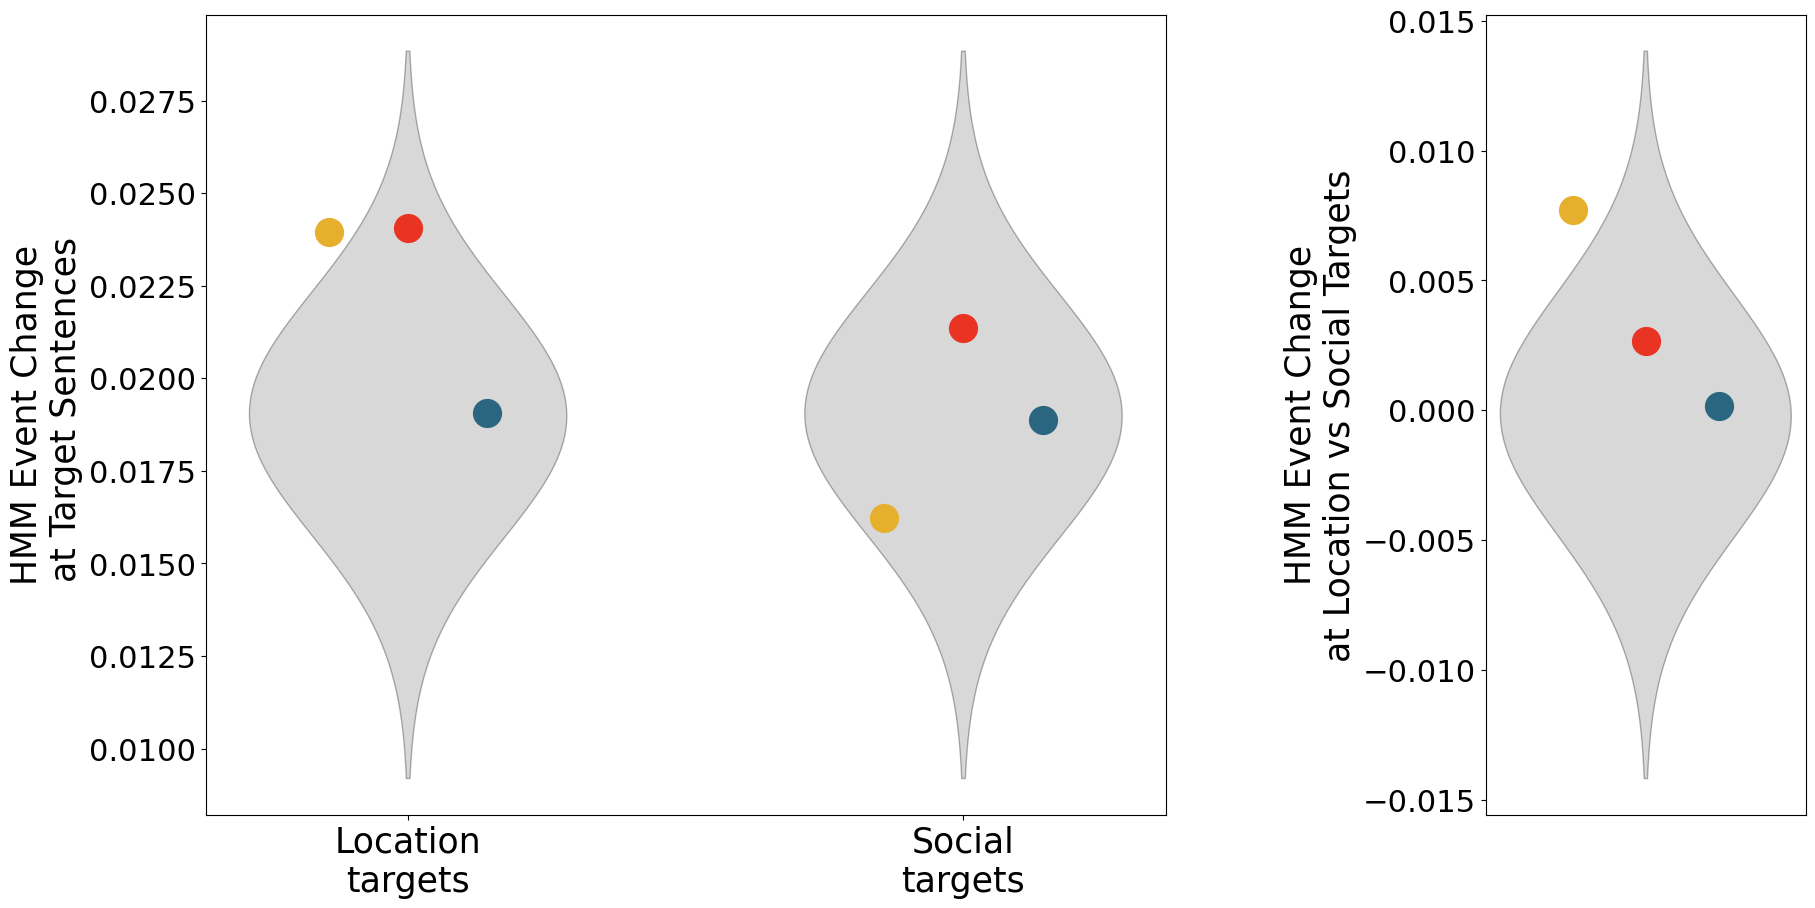

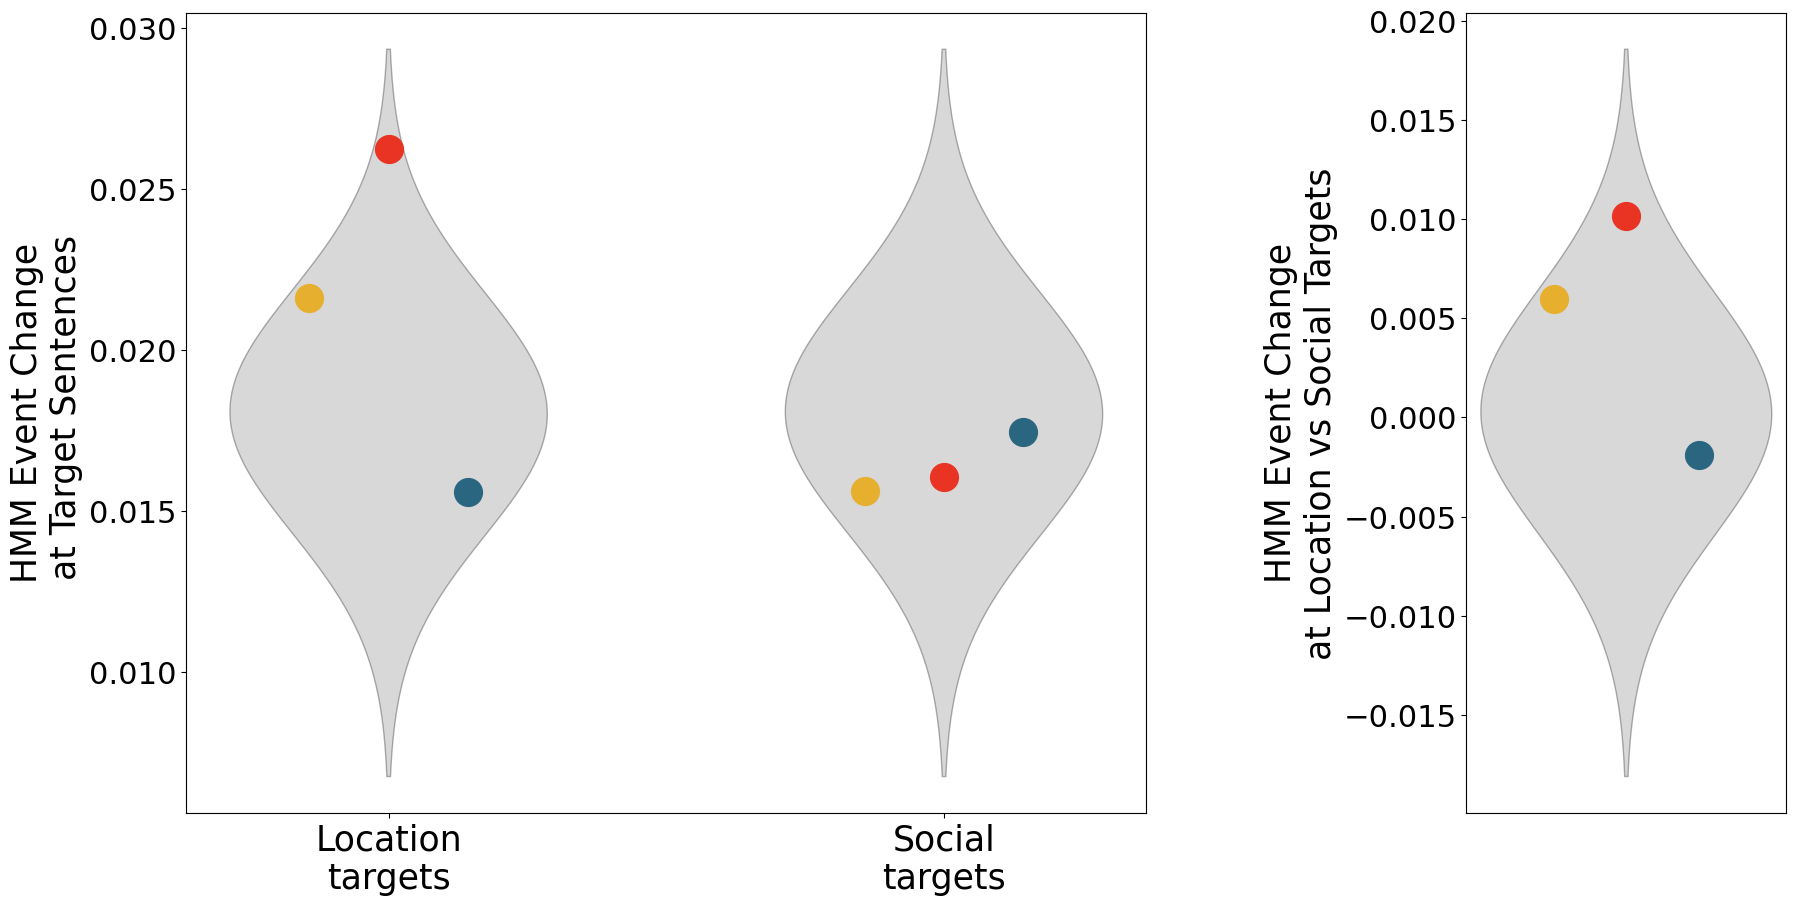

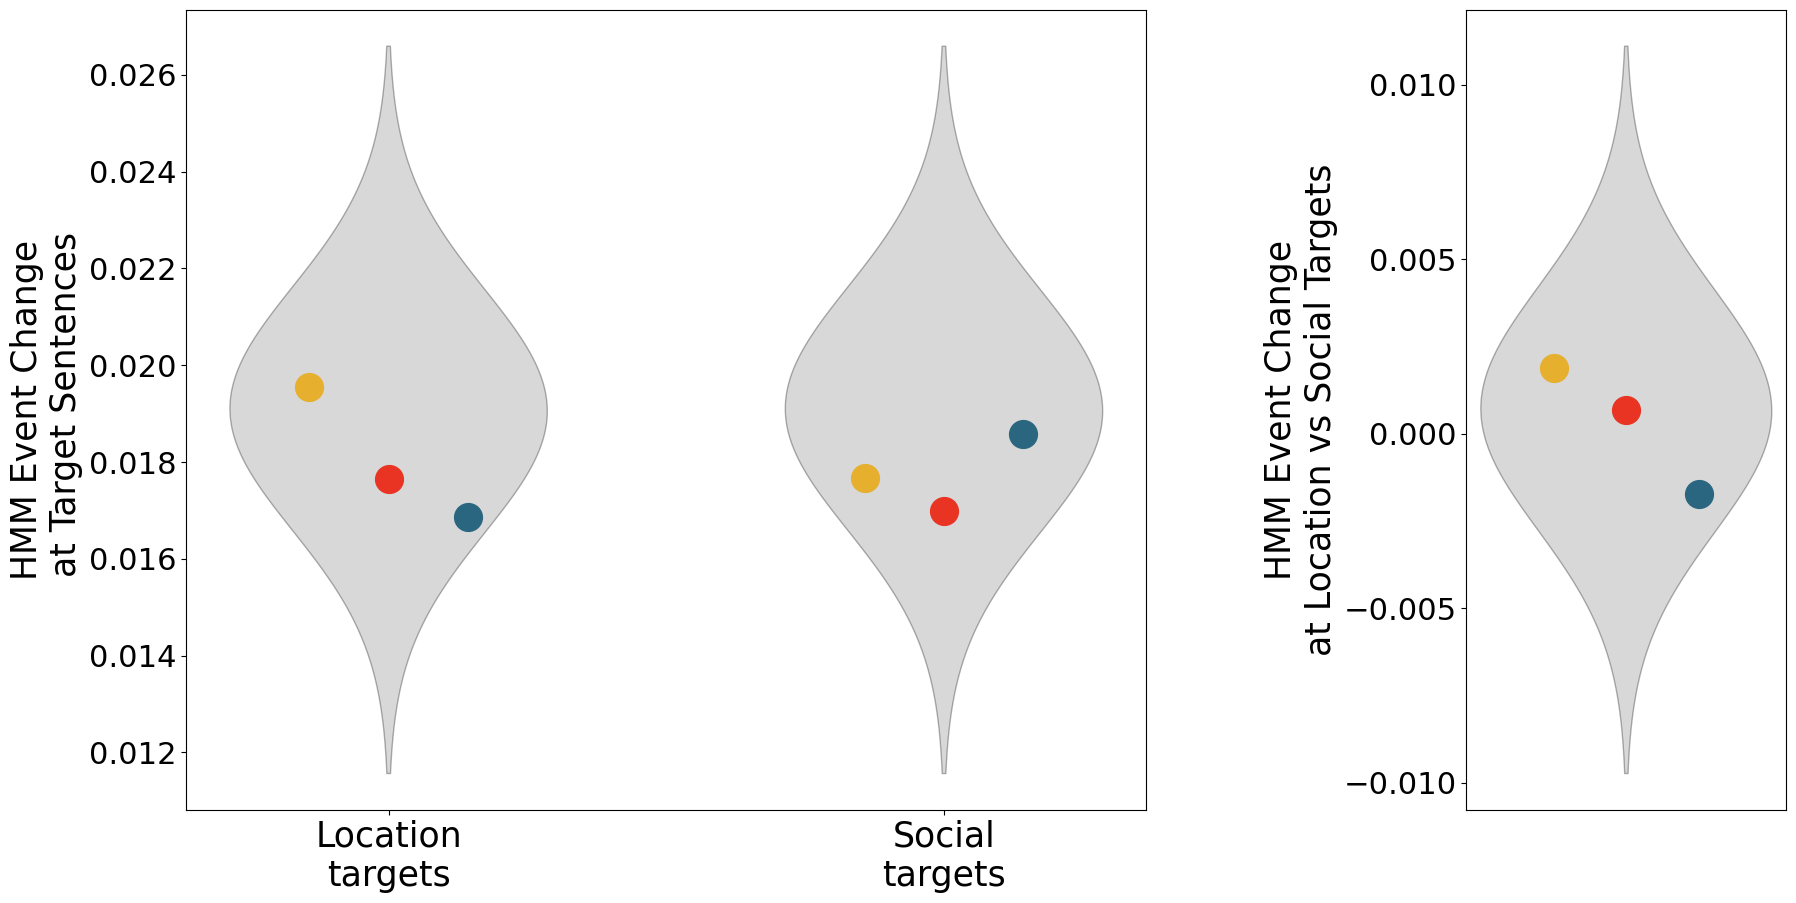

In [14]:
for roi in ['mPFC', 'Ang', 'PHC']:
    plt.rcParams['figure.figsize'] = [16, 8]
    fig = plt.figure()

    # Create an axes instance
    ax = fig.add_axes([0,0,0.6,1])

    plt.rcParams.update({'font.size': 22})
    plt.tick_params(axis='x', which='minor',bottom=False, top=False, labelbottom=False)

    priming_colors = ["#E6AF2E", "#2B6681", "#E93423"]

    # location comparisons
    ax.plot(.9, alignment[roi][0]['loc'][0], marker="o", markersize=20, markeredgecolor='#E6AF2E', markerfacecolor='#E6AF2E', linestyle="None")
    ax.plot(1, alignment[roi][2]['loc'][0], marker="o", markersize=20, markeredgecolor='#E93423', markerfacecolor='#E93423', linestyle="None")
    ax.plot(1.1, alignment[roi][1]['loc'][0], marker="o", markersize=20, markeredgecolor='#2B6681', markerfacecolor='#2B6681', linestyle="None")

    # social comparison
    shift = 0.7
    ax.plot(.9+shift, alignment[roi][0]['soc'][0], marker="o", markersize=20, markeredgecolor='#E6AF2E', markerfacecolor='#E6AF2E', linestyle="None")
    ax.plot(1+shift, alignment[roi][2]['soc'][0], marker="o", markersize=20, markeredgecolor='#E93423', markerfacecolor='#E93423', linestyle="None")
    ax.plot(1.1+shift, alignment[roi][1]['soc'][0], marker="o", markersize=20, markeredgecolor='#2B6681', markerfacecolor='#2B6681', linestyle="None")

    null =  np.concatenate((np.concatenate([alignment[roi][prime]['loc'][1:] for prime in np.arange(3)]),
                            np.concatenate([alignment[roi][prime]['soc'][1:] for prime in np.arange(3)])))

    plot_normal(1,null.mean(), null.std(), 0.4)
    plot_normal(1+shift,null.mean(), null.std(), 0.4)

    ax.set_xticks([1,1+shift], minor=False)
    ax.set_xticklabels(['Location\ntargets', 'Social\ntargets'], fontsize=25)
    ax.set_ylabel('HMM Event Change\n at Target Sentences', fontsize = 25)

    print(roi)

    # location boundaries
    print('Location targets...')
    pval = norm.sf((alignment[roi][0]['loc'][0]-null.mean())/null.std())
    print('No prime pval: ', pval)
    pval = norm.sf((alignment[roi][2]['loc'][0]-null.mean())/null.std())
    print('Loc pval: ', pval)
    pval = norm.sf((alignment[roi][1]['loc'][0]-null.mean())/null.std())
    print('Soc pval: ', pval)

    prime_diff = alignment[roi][2]['loc'] - np.mean([alignment[roi][0]['loc'], alignment[roi][1]['loc']], axis = 0)
    p = norm.sf((prime_diff[0] - prime_diff[1:].mean())/prime_diff[1:].std())
    print('loc -  non-loc dif: ', p)

    # social boundaries
    print('Social targets...')
    pval = norm.sf((alignment[roi][0]['soc'][0]-null.mean())/null.std())
    print('No prime pval: ', pval)
    pval = norm.sf((alignment[roi][2]['soc'][0]-null.mean())/null.std())
    print('Loc pval: ', pval)
    pval = norm.sf((alignment[roi][1]['soc'][0]-null.mean())/null.std())
    print('Soc pval: ', pval)

    prime_diff = np.mean([alignment[roi][0]['soc'], alignment[roi][1]['soc']], axis = 0) - alignment[roi][2]['soc']
    p = norm.sf((prime_diff[0] - prime_diff[1:].mean())/prime_diff[1:].std())
    print('non-loc - loc dif: ', p)


    ax = fig.add_axes([0.8,0,0.2,1])
    plt.rcParams.update({'font.size': 22})
    plt.tick_params(axis='x', which='minor',bottom=False, top=False, labelbottom=False)

    # diff
    bound_diff = [alignment[roi][p]['loc']-alignment[roi][p]['soc'] for p in range(3)]
    ax.plot(0.9, bound_diff[0][0], marker="o", markersize=20, markeredgecolor='#E6AF2E', markerfacecolor='#E6AF2E', linestyle="None")
    ax.plot(1, bound_diff[2][0], marker="o", markersize=20, markeredgecolor='#E93423', markerfacecolor='#E93423', linestyle="None")
    ax.plot(1.1, bound_diff[1][0], marker="o", markersize=20, markeredgecolor='#2B6681', markerfacecolor='#2B6681', linestyle="None")

    ax.set_ylabel('HMM Event Change\nat Location vs Social Targets', fontsize = 25)
    ax.set_xticks([])

    null =  np.concatenate([bound_diff[prime][1:] for prime in np.arange(3)])
    plot_normal(1,null[1:].mean(), null[1:].std(), 0.4)

    prime_diff = bound_diff[2]-np.mean(bound_diff[0:2], axis=0)
    p = norm.sf((prime_diff[0] - prime_diff[1:].mean())/prime_diff[1:].std())
    print('Overall prime effect:',p)

## Alternate: Shuffling participants between conditions

In [16]:
subj_data = dict()
alignment = dict()
for roi in ['mPFC', 'Ang', 'PHC']:
    print('Loading',roi)
    n_vox = story_dict[roi][11].shape[1]
    subj_data[roi] = {0: dict(), 1: dict(), 2: dict()}
    for story_i, story in enumerate(story_dict[roi]):
        np_all = np.zeros((0, n_vox, story_lens[story]['ISC']['L'].shape[1]))
        soc_all = np.zeros((0, n_vox, story_lens[story]['ISC']['L'].shape[1]))
        loc_all = np.zeros((0, n_vox, story_lens[story]['ISC']['L'].shape[1]))
        group_list = [np_all, soc_all, loc_all]
        # put each participant in correct priming group
        for sub_i, sub in enumerate(listen_order):
            for run in listen_order[sub]:
                for i in range(listen_order[sub][run].shape[0]):
                    if int(listen_order[sub][run][i][1]) == story:
                        this_prime = int(listen_order[sub][run][i][2])
                        this_sub = np.expand_dims(story_dict[roi][story][sub_i, :], axis=0)
                        group_list[this_prime] = np.append(group_list[this_prime], this_sub, axis=0)
        subj_data[roi][0][story] = group_list[0]
        subj_data[roi][1][story] = group_list[1]
        subj_data[roi][2][story] = group_list[2]

    alignment[roi] = dict()

    # Get each priming group's alignments with loc and soc boundaries
    prime_names = ['np', 'soc', 'loc']
    n_perms = 30
    for this_prime in [0,1,2]:
        alignment[roi][this_prime] = {'loc': np.zeros((16, n_perms+1)), 'soc': np.zeros((16, n_perms+1))}
    np.random.seed(0)
    for story_i, story in enumerate(tqdm(story_dict[roi])):
        for p in range(n_perms+1):
            if p == 0:
                subj_perm = np.arange(27)
            else:
                subj_perm = np.random.permutation(27)

            all_subj = np.concatenate((subj_data[roi][0][story], subj_data[roi][1][story], subj_data[roi][2][story]), axis=0)
            all_subj = all_subj[subj_perm]

            group_avg = [np.nanmean(all_subj[0:9],axis=0), \
                         np.nanmean(all_subj[9:18],axis=0), \
                         np.nanmean(all_subj[18:27],axis=0)]
            for this_prime in [0,1,2]:
                HMM = brainiak.eventseg.event.EventSegment(4)
                HMM.fit(group_avg[this_prime].T)

                these_segs = HMM.segments_[0]
                exp_val = np.dot(these_segs, np.arange(these_segs.shape[1]))
                np_patchange = np.diff(exp_val)

                loc_ev_len = np.diff(ev_bounds[story]['ISC']['location'])
                soc_ev_len = np.diff(ev_bounds[story]['ISC']['social'])

                alignment[roi][this_prime]['loc'][story_i, p] = np_patchange[ev_bounds[story]['ISC']['location'][1:-1]].mean()
                alignment[roi][this_prime]['soc'][story_i, p] = np_patchange[ev_bounds[story]['ISC']['social'][1:-1]].mean()

    for this_prime in [0,1,2]:
        alignment[roi][this_prime]['loc'] = alignment[roi][this_prime]['loc'].mean(0)
        alignment[roi][this_prime]['soc'] = alignment[roi][this_prime]['soc'].mean(0)

Loading mPFC


100%|██████████████████████████████████████████| 16/16 [32:44<00:00, 122.77s/it]


Loading Ang


100%|██████████████████████████████████████████| 16/16 [32:33<00:00, 122.11s/it]


Loading PHC


100%|███████████████████████████████████████████| 16/16 [20:24<00:00, 76.53s/it]


mPFC
Location boundaries...
No prime pval:  0.7600610152386691
Loc pval:  0.03326719959734188
Soc pval:  0.7983406811884837
loc -  non-loc dif:  0.027137452974209046
Social boundaries...
No prime pval:  0.08869321529582602
Loc pval:  0.8303124509845861
Soc pval:  0.15367754261567357
non-loc - loc dif:  0.016613479590938295
Overall prime effect: 0.004389627035559021
Ang
Location boundaries...
No prime pval:  0.7945560131041669
Loc pval:  0.6736528786199608
Soc pval:  0.5483720726166491
loc -  non-loc dif:  0.5013351649585142
Social boundaries...
No prime pval:  0.08701275551903959
Loc pval:  0.8745482599744938
Soc pval:  0.13804224378784619
non-loc - loc dif:  0.0066255644408900185
Overall prime effect: 0.09125556872732771
PHC
Location boundaries...
No prime pval:  0.281686539155404
Loc pval:  0.14913512969162068
Soc pval:  0.7423417014441407
loc -  non-loc dif:  0.092008606258701
Social boundaries...
No prime pval:  0.5099874791822483
Loc pval:  0.9040668826146926
Soc pval:  0.73546647

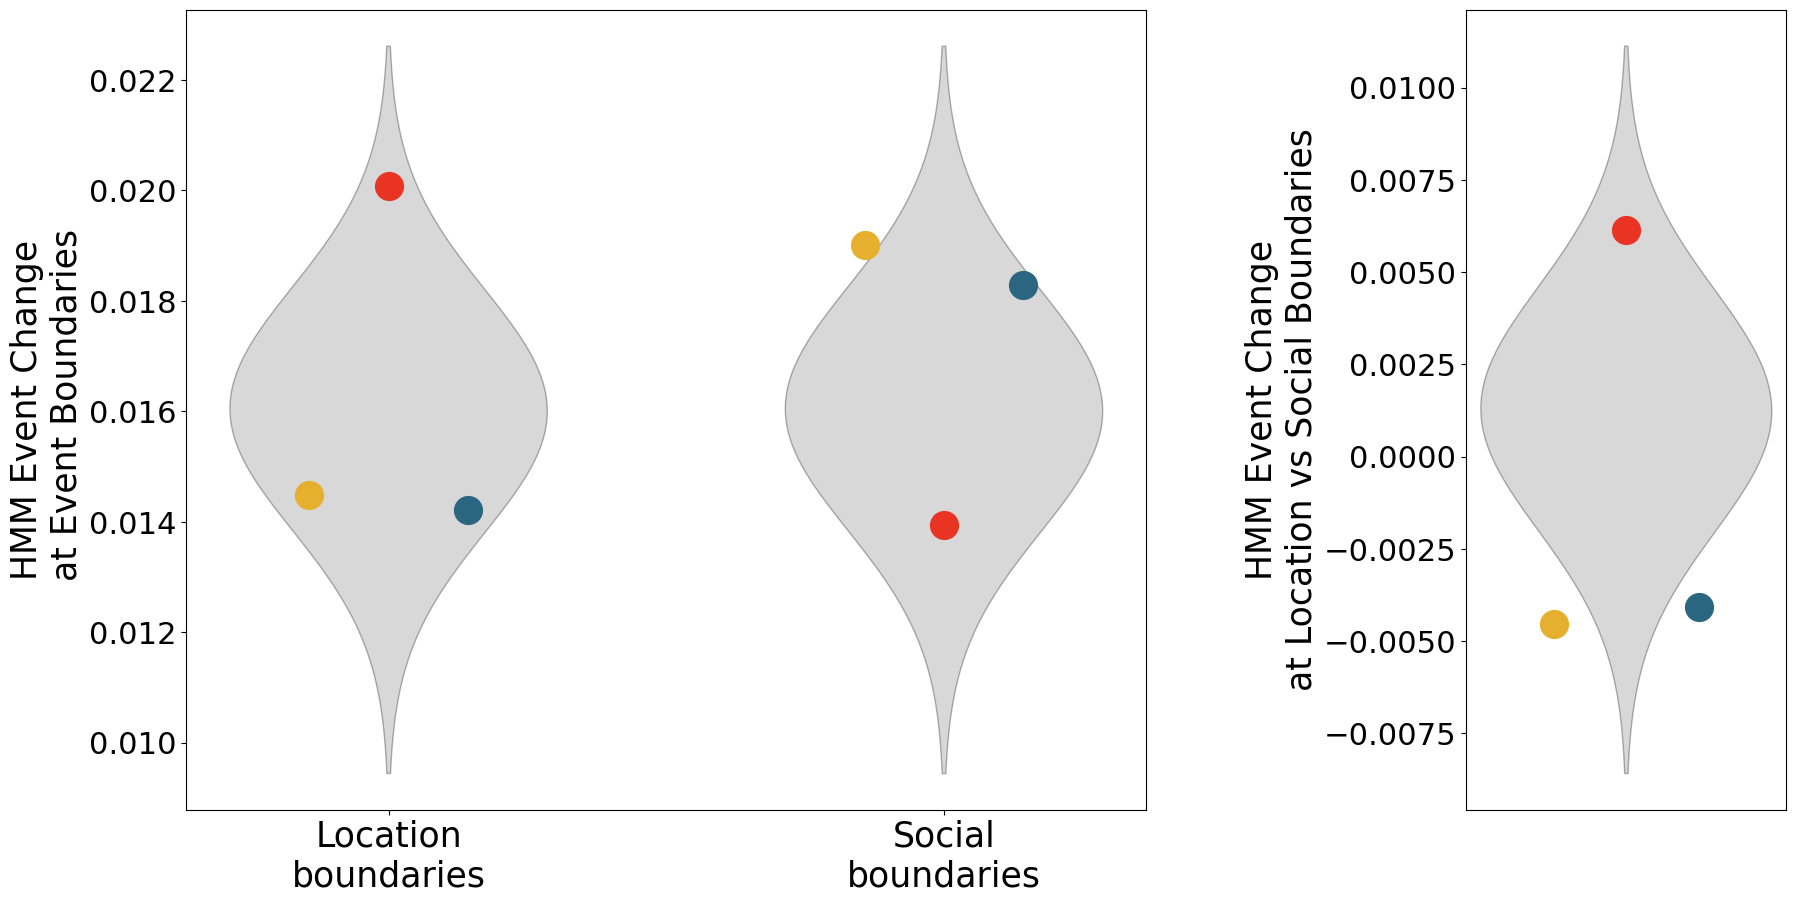

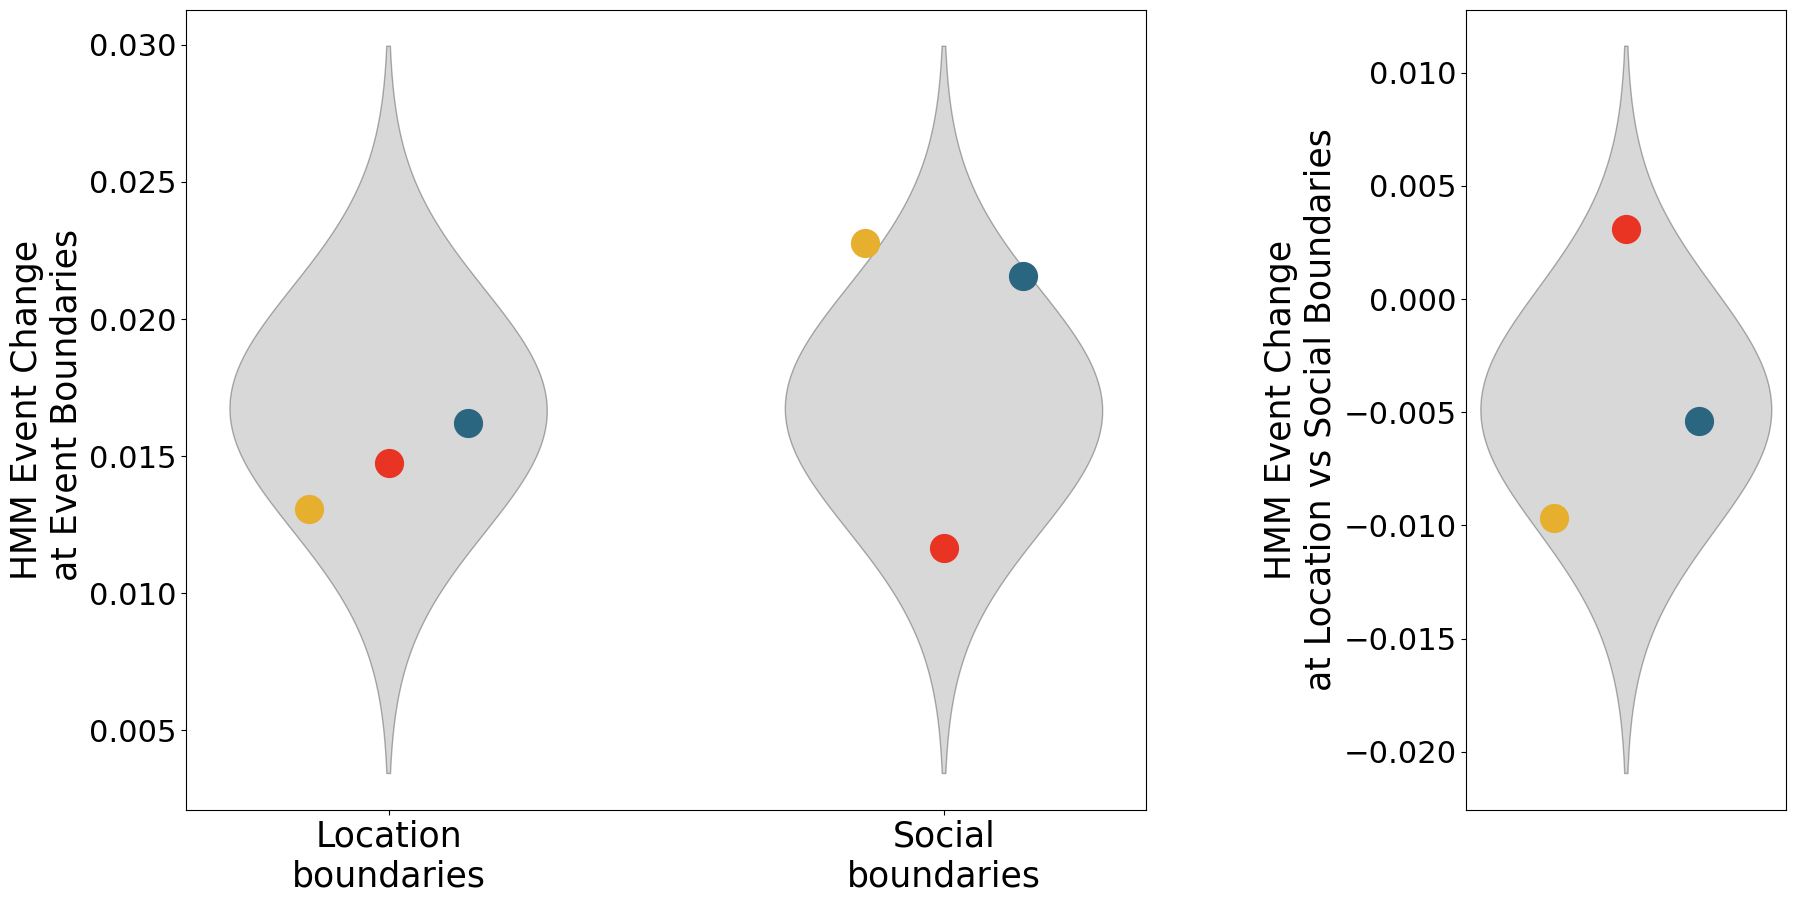

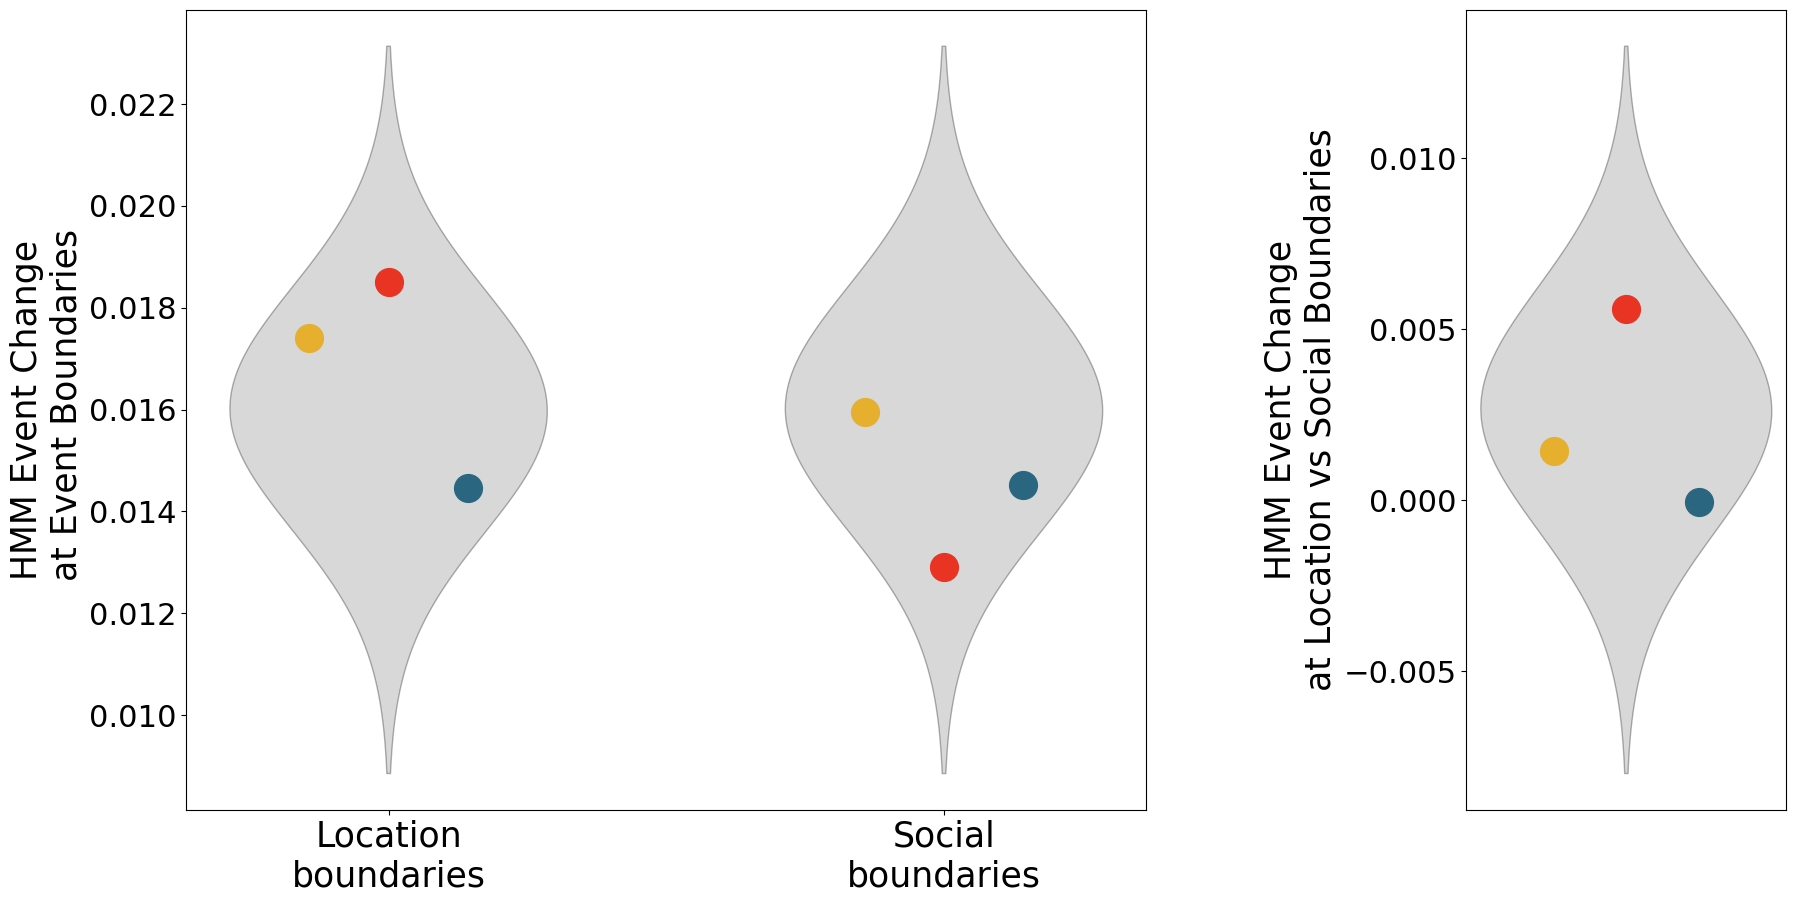

In [17]:
plot_results(alignment)

# Alternate: hippocampus

In [20]:
story_dict_hipp = joblib.load('Preprocessing/pickle/hipp_storydict_ISC_36_80.sav')
roi = 'hipp'
story_dict[roi] = story_dict_hipp

print('Running ', roi, '...')
n_vox = story_dict[roi][11].shape[1]
cond_avg[roi] = {0: dict(), 1: dict(), 2: dict()}
for story_i, story in enumerate(story_dict[roi]):
    np_all = np.zeros((0, n_vox, story_lens[story]['ISC']['L'].shape[1]))
    soc_all = np.zeros((0, n_vox, story_lens[story]['ISC']['L'].shape[1]))
    loc_all = np.zeros((0, n_vox, story_lens[story]['ISC']['L'].shape[1]))
    group_list = [np_all, soc_all, loc_all]
    # put each participant in correct priming group
    for sub_i, sub in enumerate(listen_order):
        for run in listen_order[sub]:
            for i in range(listen_order[sub][run].shape[0]):
                if int(listen_order[sub][run][i][1]) == story:
                    this_prime = int(listen_order[sub][run][i][2])
                    this_sub = np.expand_dims(story_dict[roi][story][sub_i, :], axis=0)
                    group_list[this_prime] = np.append(group_list[this_prime], this_sub, axis=0)
    cond_avg[roi][0][story] = np.nanmean(group_list[0], axis=0)
    cond_avg[roi][1][story] = np.nanmean(group_list[1], axis=0)
    cond_avg[roi][2][story] = np.nanmean(group_list[2], axis=0)

Running  hipp ...


In [21]:
alignment = dict()

roi = 'hipp'
print('Running ', roi, '...')
alignment[roi] = dict()

# Get each priming group's alignments with loc and soc boundaries
prime_names = ['np', 'soc', 'loc']
n_perms = 24

for this_prime in [0,1,2]:
    alignment[roi][this_prime] = {'loc': np.zeros((16, n_perms)), 'soc': np.zeros((16, n_perms))}
    for story_i, story in enumerate(story_dict[roi]):
        group_avg = cond_avg[roi][this_prime][story]
        HMM = brainiak.eventseg.event.EventSegment(4)
        HMM.fit(group_avg.T)

        these_segs = HMM.segments_[0]
        exp_val = np.dot(these_segs, np.arange(these_segs.shape[1]))
        np_patchange = np.diff(exp_val)

        loc_ev_len = np.diff(ev_bounds[story]['ISC']['location'])
        soc_ev_len = np.diff(ev_bounds[story]['ISC']['social'])

        alignment[roi][this_prime]['loc'][story_i, :] = \
            [np_patchange[np.cumsum(ev_order)[0:3]].mean() for ev_order in itertools.permutations(loc_ev_len)]
        alignment[roi][this_prime]['soc'][story_i, :] = \
            [np_patchange[np.cumsum(ev_order)[0:3]].mean() for ev_order in itertools.permutations(soc_ev_len)]

    alignment[roi][this_prime]['loc'] = alignment[roi][this_prime]['loc'].mean(0)
    alignment[roi][this_prime]['soc'] = alignment[roi][this_prime]['soc'].mean(0)                

Running  hipp ...


In [22]:
roi = 'hipp'
null =  np.concatenate((np.concatenate([alignment[roi][prime]['loc'][1:] for prime in np.arange(3)]),
                        np.concatenate([alignment[roi][prime]['soc'][1:] for prime in np.arange(3)])))

# location boundaries
print('Location boundaries...')
pval = norm.sf((alignment[roi][2]['loc'][0]-null.mean())/null.std())
print('Loc pval: ', pval)

# social boundaries
print('Social boundaries...')
pval = norm.sf((alignment[roi][0]['soc'][0]-null.mean())/null.std())
print('No prime pval: ', pval)
pval = norm.sf((alignment[roi][1]['soc'][0]-null.mean())/null.std())
print('Soc pval: ', pval)

Location boundaries...
Loc pval:  0.0666404217871519
Social boundaries...
No prime pval:  0.10657897047468728
Soc pval:  0.918637563963605
